In [7]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = Path("../data")
OUTPUT_DIR = BASE_DIR / "processed_data"
MERGED_OUTPUT = BASE_DIR / "merged_eye_data.csv"
MAIN_FOLDER = "../STData"

In [2]:
def load_eye_participant_data(participant_dir):
    """
        Loads EYE dataset for a single participant.
    """
    try:
        eye_path = glob.glob(os.path.join(participant_dir, "**", "*_EYE.csv"), recursive=True)
    except:
        print(f"Missing files in {participant_dir}")
        return None
    
    eye_df_list = []
    for eye_file in eye_path:
        temp_eye_df = pd.read_csv(eye_file)

        participant_id = os.path.basename(os.path.dirname(eye_file))
        temp_eye_df["participant_id"] = participant_id

        eye_df_list.append(temp_eye_df)   

    merged_eye_df = pd.concat(eye_df_list, ignore_index=True)
    merged_eye_df.to_csv("../data/raw/all_participants_eye_raw_dataset.csv", index=False)
    print("Merged Eye CSV created successfull!")

    return merged_eye_df

In [3]:
def load_ivt_participant_data(participant_dir):
    """
        Loads IVT dataset for a single participant.
    """
    try:
        ivt_path = glob.glob(os.path.join(participant_dir, "**", "*_IVT.csv"), recursive=True)
    except:
        print(f"Missing files in {participant_dir}")
        return None

    ivt_df_list = []
    for ivt_file in ivt_path:
        temp_ivt_df = pd.read_csv(ivt_file)

        participant_id = os.path.basename(os.path.dirname(ivt_file))
        temp_ivt_df["participant_id"] = participant_id

        ivt_df_list.append(temp_ivt_df)   

    merged_ivt_df = pd.concat(ivt_df_list, ignore_index=True)
    merged_ivt_df.to_csv("../data/raw/all_participants_ivt_raw_dataset.csv", index=False)
    print("Merged IVT CSV created successfull!")

    return merged_ivt_df

In [4]:
def feature_engineering(main_folder):
    all_participant_features = []
    for participant_folder in glob.glob(os.path.join(main_folder, '[0-9]*')):
        participant_id = os.path.basename(participant_folder)
        try:
            eye_path = glob.glob(os.path.join(participant_folder, '**', '*_EYE.csv'), recursive=True)[0]
            ivt_path = glob.glob(os.path.join(participant_folder, '**', '*_IVT.csv'), recursive=True)[0]
        except IndexError:
            print(f"Skipping participant {participant_id} due to missing EYE or IVT files.")
            continue

        eye_df = pd.read_csv(eye_path)
        ivt_df = pd.read_csv(ivt_path)

        eye_df['Timestamp'] = pd.to_datetime(eye_df['Timestamp'], errors='coerce')
        ivt_df['Timestamp'] = pd.to_datetime(ivt_df['Timestamp'], errors='coerce')

        eye_numeric_cols = eye_df.select_dtypes(include=[np.number]).columns
        eye_outlier_cols = []
        for col in eye_numeric_cols:
            Q1 = eye_df[col].quantile(0.25)
            Q3 = eye_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            if((eye_df[col] < lower) | (eye_df[col] > upper)).any():
                eye_outlier_cols.append(col)

        for col in eye_df.columns:
            if eye_df[col].isnull().any():
                if col in eye_outlier_cols:
                    eye_df[col] = eye_df[col].fillna(eye_df[col].median())
                elif eye_df[col].dtype in ["float64", "int64"]:
                    eye_df[col] = eye_df[col].fillna(eye_df[col].mean())
                else:
                    eye_df[col] = eye_df[col].fillna(eye_df[col].mode()[0])

        eye_df['PupilAvg'] = (eye_df['ET_PupilLeft'] + eye_df['ET_PupilRight']) / 2
        pupil_mean = eye_df['PupilAvg'].mean()
        pupil_std = eye_df['PupilAvg'].std()

        ivt_numeric_cols = ivt_df.select_dtypes(include=[np.number]).columns
        ivt_outlier_cols = []
        for col in ivt_numeric_cols:
            Q1 = ivt_df[col].quantile(0.25)
            Q3 = ivt_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            if((ivt_df[col] < lower) | (ivt_df[col] > upper)).any():
                ivt_outlier_cols.append(col)

        for col in ivt_df.columns:
            if ivt_df[col].isnull().any():
                if col in ivt_outlier_cols:
                    ivt_df[col] = ivt_df[col].fillna(ivt_df[col].median())
                elif ivt_df[col].dtype in ["float64", "int64"]:
                    ivt_df[col] = ivt_df[col].fillna(ivt_df[col].mean())
                else:
                    ivt_df[col] = ivt_df[col].fillna(ivt_df[col].mode()[0])

        fixation_mean = ivt_df['Fixation Duration'].mean()
        fixation_std = ivt_df['Fixation Duration'].std()
        n_fix = ivt_df['Fixation Index'].nunique()

        saccade_mean = ivt_df['Saccade Amplitude'].mean()
        saccade_std = ivt_df['Saccade Amplitude'].std()
        n_sacc = ivt_df['Saccade Index'].nunique()

        participant_features = {
            'participant_id': participant_id,
            'fixation_mean': fixation_mean,
            'fixation_std': fixation_std,
            'n_fixations': n_fix,
            'saccade_mean': saccade_mean,
            'saccade_std': saccade_std,
            'n_saccades': n_sacc,
            'pupil_mean': pupil_mean,
            'pupil_std': pupil_std
        }
        all_participant_features.append(participant_features)

    return all_participant_features

In [5]:
participant_features = feature_engineering(MAIN_FOLDER)
merged_participants_df = pd.DataFrame(participant_features)
merged_participants_df.to_csv('../data/processed/merged_participants.csv', index=False)
print('Merged participants CSV created successfully!')

C:\Users\pooja\AppData\Local\Temp\ipykernel_14852\2160412535.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  eye_df = pd.read_csv(eye_path)
C:\Users\pooja\AppData\Local\Temp\ipykernel_14852\2160412535.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ivt_df = pd.read_csv(ivt_path)
C:\Users\pooja\AppData\Local\Temp\ipykernel_14852\2160412535.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  eye_df = pd.read_csv(eye_path)
C:\Users\pooja\AppData\Local\Temp\ipykernel_14852\2160412535.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ivt_df = pd.read_csv(ivt_path)
C:\Users\pooja\AppData\Local\Temp\ipykernel_14852\2160412535.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  eye_df = pd.read_csv(eye_p

Merged participants CSV created successfully!


In [9]:
df = pd.read_csv("../data/processed/merged_participants.csv")
print(f"Shape of dataset: {df.shape}")
df.head()

Shape of dataset: (38, 9)


,participant_id,fixation_mean,fixation_std,n_fixations,saccade_mean,saccade_std,n_saccades,pupil_mean,pupil_std
0,1,513.945607,886.380811,2115,6.188820,1.839694,2493,0.107833,1.733788
1,10,351.878900,242.404162,3261,3.847675,1.661681,3561,0.246597,1.906057
2,11,321.162855,248.388105,3743,3.446144,1.823703,4140,0.104711,1.786552
3,12,261.089310,186.040553,2744,2.362305,1.900754,4417,-0.232557,1.375267
4,13,476.664924,745.206894,3531,3.680020,1.527838,3879,0.392761,2.065245


In [10]:
df.isnull().sum()

participant_id    0
fixation_mean     1
fixation_std      1
n_fixations       0
saccade_mean      0
saccade_std       0
n_saccades        0
pupil_mean        0
pupil_std         0
dtype: int64

In [11]:
df.dtypes

participant_id      int64
fixation_mean     float64
fixation_std      float64
n_fixations         int64
saccade_mean      float64
saccade_std       float64
n_saccades          int64
pupil_mean        float64
pupil_std         float64
dtype: object

In [12]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [13]:
df.isnull().sum()

participant_id    0
fixation_mean     0
fixation_std      0
n_fixations       0
saccade_mean      0
saccade_std       0
n_saccades        0
pupil_mean        0
pupil_std         0
dtype: int64

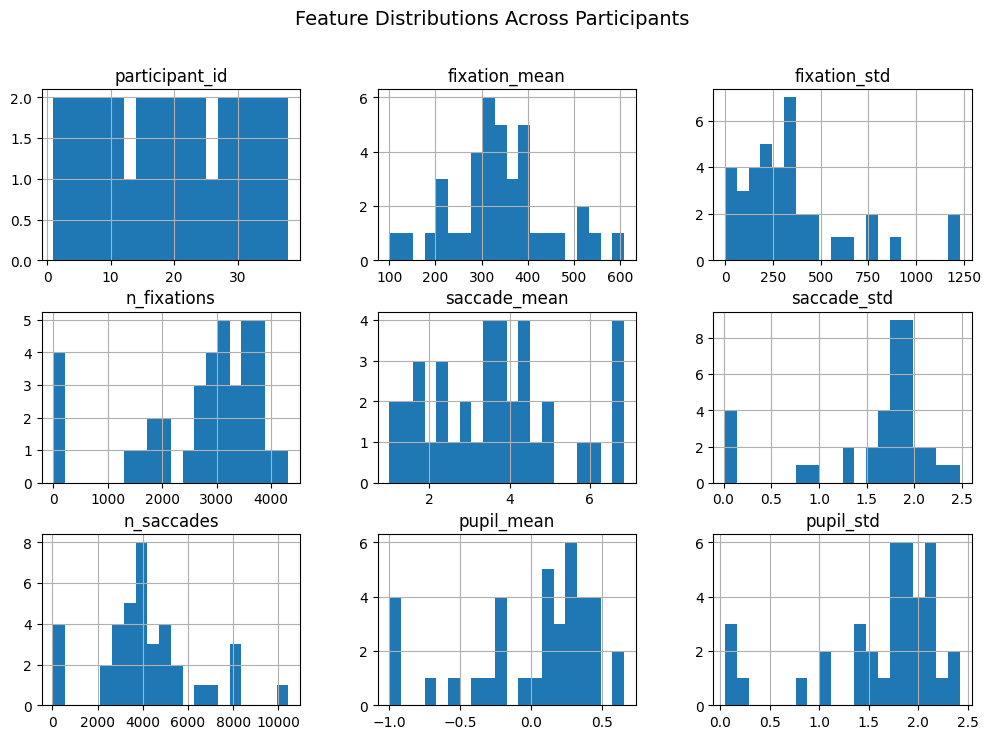

In [14]:
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions Across Participants", fontsize=14)
plt.show()

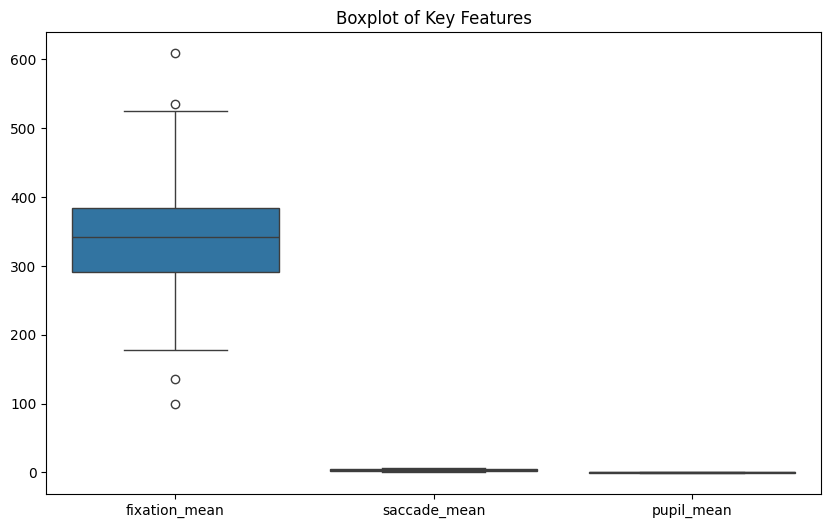

In [15]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[["fixation_mean", "saccade_mean", "pupil_mean"]])
plt.title("Boxplot of Key Features")
plt.show()

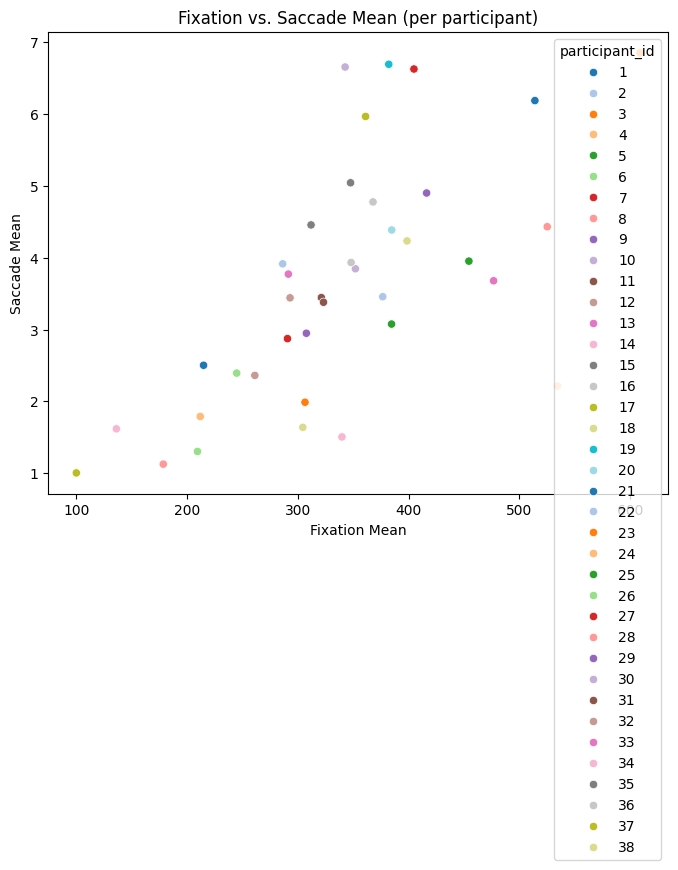

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='fixation_mean', y='saccade_mean', data=df, hue='participant_id', palette='tab20')
plt.title("Fixation vs. Saccade Mean (per participant)")
plt.xlabel("Fixation Mean")
plt.ylabel("Saccade Mean")
plt.show()